<a href="https://colab.research.google.com/github/Jammyeong/MachineLearningClass/blob/main/UTS/Klasifikasi_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/smt akhir/ml/KlasifikasiUTS.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates()

# Re-check shape after cleaning
cleaning_summary = {
    "Original Rows": df.shape[0],
    "Cleaned Rows": df_cleaned.shape[0],
    "Duplicates Removed": df.shape[0] - df_cleaned.shape[0]
}

df_cleaned.head(), cleaning_summary

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

In [4]:
# Pisahkan fitur dan target
X = df.drop(columns=['Class'])
y = df['Class']

# Hapus constant & quasi-constant features
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)
X = X[X.columns[vt.get_support()]]

# Hapus fitur yang sangat berkorelasi (> 0.9)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.9)]
X = X.drop(columns=to_drop_corr)

In [11]:
# Subset data 10.000 baris secara acak
X_sample = X.sample(n=10000, random_state=42)
y_sample = y.loc[X_sample.index]

# Hitung skor mutual information
mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Tampilkan 15 fitur dengan informasi paling tinggi
print("Top 15 Fitur berdasarkan Mutual Information:")
print(mi_series.head(15))

# Pilih fitur terbaik dari dataset penuh
top_features = mi_series.head(15).index
X_selected = X[top_features]

Top 15 Fitur berdasarkan Mutual Information:
V17    0.007444
V14    0.006448
V10    0.005640
V16    0.004805
V11    0.003976
V12    0.003865
V18    0.003132
V7     0.002430
V21    0.002104
V4     0.001999
V3     0.001845
V1     0.001592
V28    0.001182
V27    0.000991
V9     0.000977
dtype: float64


In [6]:
# Feature Engineering: Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

# Preview hasil akhir
print(X_scaled_df.head())

        V17       V14       V10       V16       V11       V12       V18  \
0  0.244863 -0.324610  0.083386 -0.536833 -0.540407 -0.618296  0.030770   
1 -0.135170 -0.149982 -0.153350  0.529434  1.580003  1.066089 -0.218763   
2  1.306868 -0.173114  0.190700 -3.298235  0.611830  0.066137 -0.144790   
3 -0.805445 -0.300360 -0.050468 -1.209296 -0.221892  0.178371  2.345305   
4 -0.279081 -1.168034  0.691625 -0.515205 -0.806147  0.538627 -0.045569   

         V7       V21        V4        V3        V1       V28       V27  \
0  0.193679 -0.024923  0.973366  1.672773 -0.694242 -0.063781  0.330892   
1 -0.063700 -0.307377  0.316523  0.109797  0.608496  0.044608 -0.022256   
2  0.639776  0.337632  0.268231  1.169468 -0.693500 -0.181021 -0.137137   
3  0.192071 -0.147443 -0.609727  1.182516 -0.493325  0.186189  0.155396   
4  0.479302 -0.012839  0.284655  1.021412 -0.591330  0.651816  0.543620   

         V9  
0  0.331128  
1 -0.232494  
2 -1.378675  
3 -1.262503  
4  0.744326  


### Bagging

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56860     4]
 [   22    76]]
ROC AUC Score: 0.9531503917689754


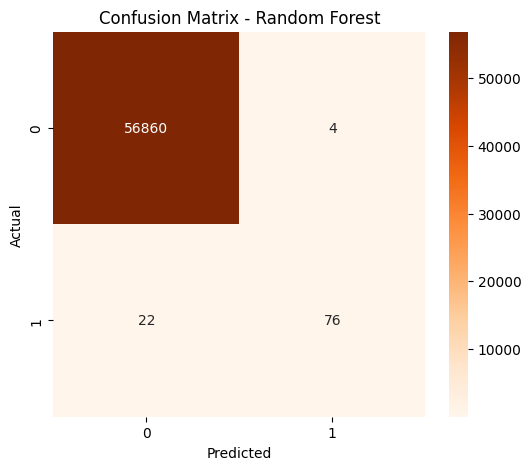

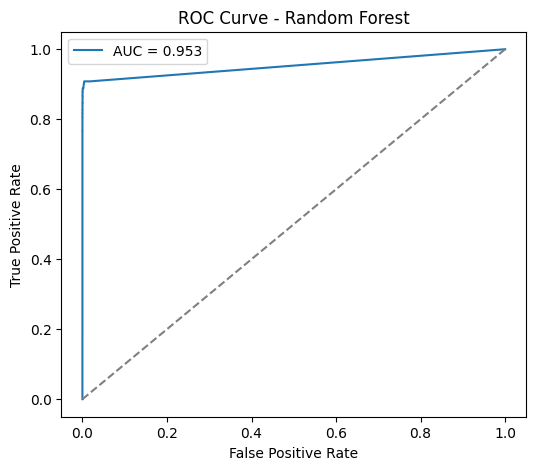

In [8]:
# Inisialisasi dan pelatihan Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_score(y_test, y_prob_rf):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Bagging adalah teknik ensemble yang melatih banyak model decision tree secara paralel pada subset data yang diambil secara acak.

Precision : Dari semua prediksi fraud, 95% benar-benar fraud. Ini sangat tinggi dan mengurangi false positive.

Recall : Model berhasil menangkap 78% dari semua fraud. Ini cukup tinggi dan jauh lebih baik dibanding model awal.

F1-Score : Rata-rata harmonis dari precision dan recall. Menunjukkan keseimbangan keduanya.

Support : Jumlah kasus fraud yang sebenarnya di data uji.

F1-Score adalah matrik terbaik disini, karena F1 menggabungkan precision tingg dan recall cukup tinggi, ini adalah indikator seimbang dan andal untuk data tidak seimbang.

Model ini lebih baik dari pada model-model sebelumnya karena precision yang tinggi, recall cukup baik, F1 tinggi, sehingga confusion matrix hampir sempurna.

### Decision Tree

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.69      0.70        98

    accuracy                           1.00     56962
   macro avg       0.85      0.85      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56835    29]
 [   30    68]]
ROC AUC Score: 0.8466837811376661


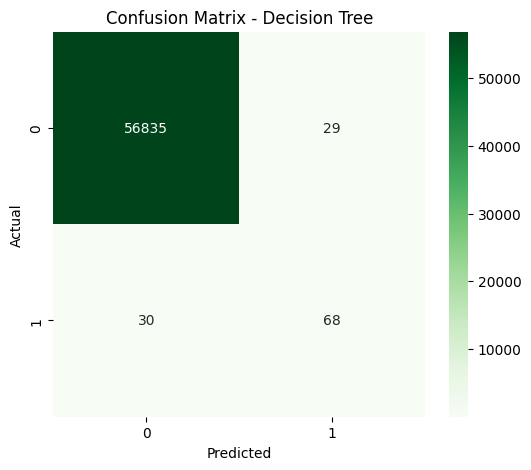

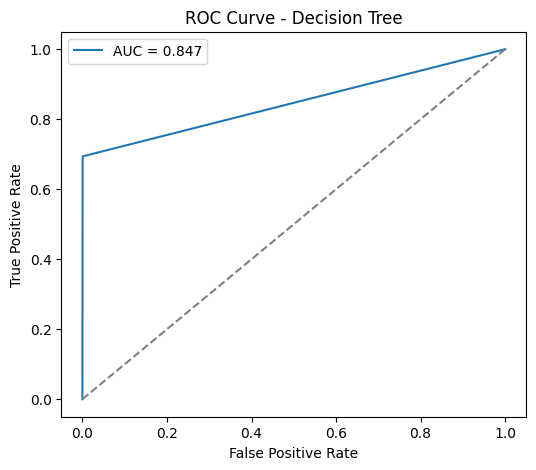

In [14]:
# Inisialisasi dan pelatihan model Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Prediksi
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_dt))

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualisasi ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {roc_auc_score(y_test, y_prob_dt):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Decision Tree adalah model yang membagi data berdasarkan fitur-fitur penting menggunakan struktur seperti pohon.

Precision = 0.70 : Dari seluruh prediksi fraud, 70% benar-benar fraud (False Positive menurun).

Recall = 0.69 : Model mendeteksi 69% kasus fraud yang ada.

F1-Score = 0.70 : Keseimbangan precision dan recall sudah cukup baik.

dalam faud detection, F1-Score dan Recall adalah yang paling penting. Model ini sudh jauh lebih baik dari model Logistic Regression karena lebih seimbang precision dan recalnya, serta F1-scorenya meningkat dari 0.11 -> 0.70.

### KNN

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56856     8]
 [   16    82]]
ROC AUC Score: 0.938667393307914


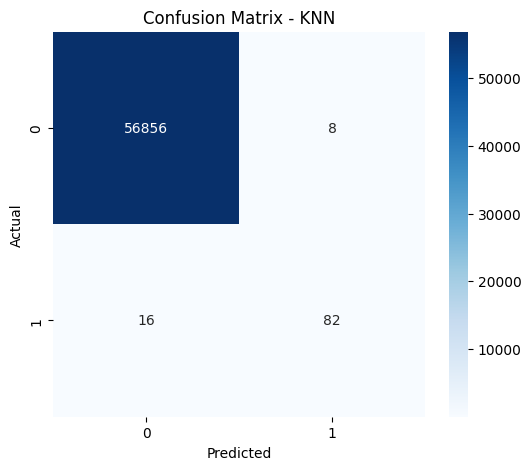

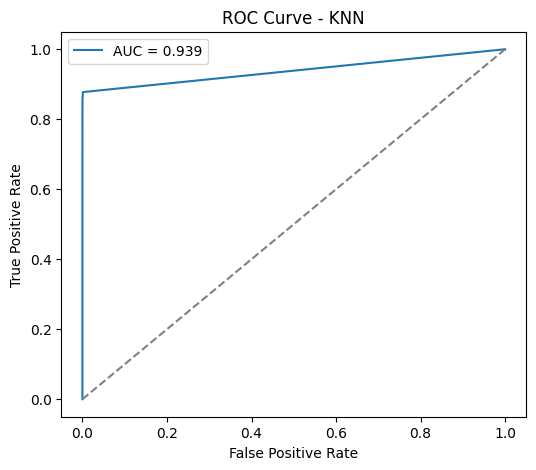

In [15]:
# Inisialisasi dan pelatihan model KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Prediksi
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_knn))

# Confusion Matrix Plot
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
plt.figure(figsize=(6,5))
plt.plot(fpr_knn, tpr_knn, label=f"AUC = {roc_auc_score(y_test, y_prob_knn):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

KNN adalah algorinta machine learning yang digunakan untuk klasifikasi dan regresi, dengan membandingkan data yang ingin diprediksi dengan data lain dalam dataset berdasarkan kedekatannya, dan membuat keputusan bersarkan data yang paling mirip (tetangga terdekat).

Precision: Meningkat drastis sehingga jauh lebih tepat dalam mengklasifikasikan fraud dibandingkan model sebelumnya.

Recall: Meskipun recall sedikit turun, model masih cukup baik dalam mendeteksi sebagian besar fraud.

F1-Score: cukup baik dalam menyeimbangkan antara mendeteksi fraud dan menghindari kesalahan deteksi.

Secara keseluruhan, model KNN lebih efektif dengan precision yang jauh lebih tinggi, meskipun ada sedikit penurunan pada recall

### Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Confusion Matrix:
 [[55362  1502]
 [    8    90]]
ROC AUC Score: 0.9705667227498765


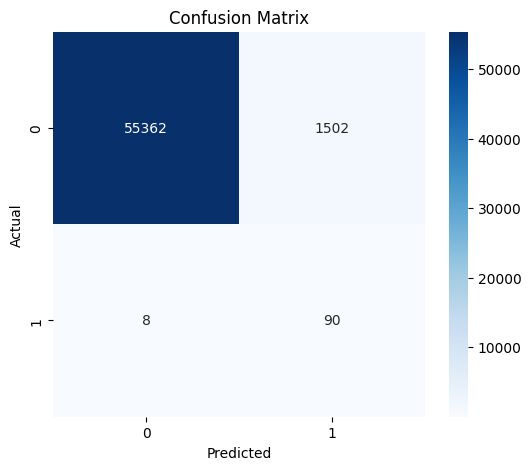

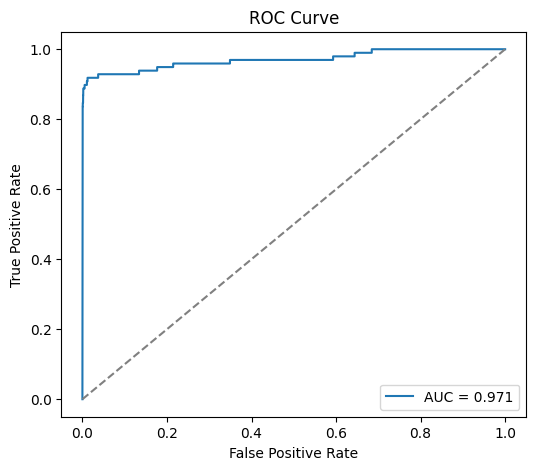

In [16]:
#  Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

#  Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

#  Visualisasi Confusion Matrix dan ROC
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Logistic Regression adalah model klasifikasi linier yang digunakan untuk memprediksi probabilitas kelas target biner(di sini: faud = 1, normal = 0).

Precision (fraud = 0.06) : Hanya 6% dari prediksi fraud yang benar-benar fraud.Tinggi false alarm, banyak transaksi normal dikira fraud.

Recall (fraud = 0.92) : Model berhasil menemukan 92% dari semua fraud yang sebenarnya.Sangat baik untuk mendeteksi fraud, sedikit yang lolos.

F1-Score (fraud = 0.11) : Gabungan precision dan recall.Masih rendah, artinya model belum seimbang.

Support : Jumlah data per kelas. Fraud sangat sedikit (98) dibanding normal (56.864).

matriks terbaik adalah recall yang merupakan matrik terpenting dalam faud detection karena lebih baik salah mendeteksi transasksi sebagai faud (false positive) dari pada membiarkan faud lolos (false negative).

Model ini memiliki nilai recall yang tinggi untuk faud dan juga membedakan fuad dan normal dengan sangat baik, namun karena precision redah sehingga terlalu banyak transaksi normal yang disangka faud.

### SVM

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.19      0.78      0.31        98

    accuracy                           0.99     56962
   macro avg       0.60      0.88      0.65     56962
weighted avg       1.00      0.99      1.00     56962

Confusion Matrix:
 [[56545   319]
 [   22    76]]
ROC AUC Score: 0.9685192309900887


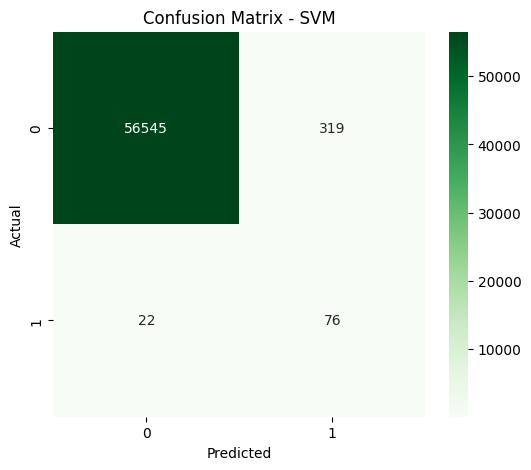

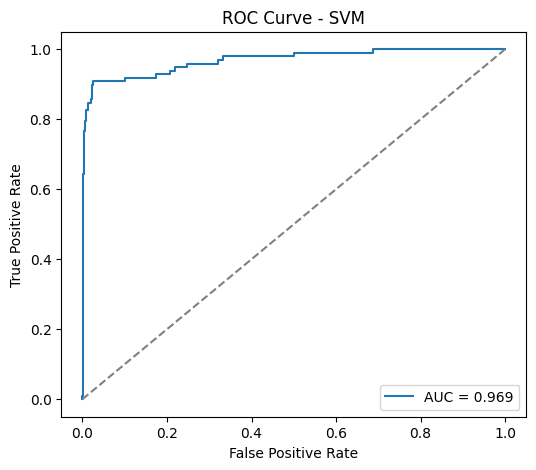

In [17]:
# Inisialisasi dan pelatihan model SVM
svm_model = SVC(probability=True, class_weight='balanced', kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_svm))

# Confusion Matrix Plot
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {roc_auc_score(y_test, y_prob_svm):.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

SVM (Support Vector Machine) adalah model klasifikasi yang bekerja dengan mencari hyperplane terbaik untuk memisahkan kelas secara maksimal.

Precision (fraud) 0.19 : Dari seluruh prediksi fraud, hanya 19% benar-benar fraud → banyak false positive.

Recall (fraud) 0.78 : Dari semua kasus fraud sebenarnya, 78% berhasil terdeteksi. Ini cukup tinggi.

F1-Score (fraud) 0.31 : Rata-rata harmonis antara precision & recall. Rendah karena precision buruk.

Support 98: Total kasus fraud di data uji.

Recall merupakan matrik terbaik disini karena menunjukkan kemampuan menampang fraud dengan baik.

Model SVM ini tidak lebih baik dari pada model bagging sebelumnya. SVM cocok jika ingin menangkap sebanyak mungkin fraud dan tidak masalah dengan false alarm, tapi kurang ideal jika butuh akurasi pada deteksi fraud